In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "last"

pd.set_option('display.max_rows', 10000)

# EDA for EIA data

In [2]:
## Load in EIA data
eia_data = pd.read_feather('eia.feather')
## Convert `period` to datetime and `value` to numeric
eia_data['date_time'] = pd.to_datetime(eia_data['period'], format='%Y-%m-%dT%H')
eia_data['value'] = pd.to_numeric(eia_data['value'])
## Drop `period` column
eia_data.drop('period', axis=1, inplace=True)
## Print out info about data
eia_data.info(show_counts=True)


<class 'pandas.core.frame.DataFrame'>
Index: 1760000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   respondent       1760000 non-null  object        
 1   respondent-name  1760000 non-null  object        
 2   fueltype         1760000 non-null  object        
 3   type-name        1760000 non-null  object        
 4   value            1760000 non-null  int64         
 5   value-units      1760000 non-null  object        
 6   date_time        1760000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 107.4+ MB


In [3]:
eia_data.head()

,respondent,respondent-name,fueltype,type-name,value,value-units,date_time
0,CAL,California,COL,Coal,899,megawatthours,2022-12-31
1,CAL,California,NG,Natural Gas,10335,megawatthours,2022-12-31
2,CAL,California,NUC,Nuclear,2248,megawatthours,2022-12-31
3,CAL,California,OIL,Petroleum,83,megawatthours,2022-12-31
4,CAL,California,OTH,Other,1097,megawatthours,2022-12-31


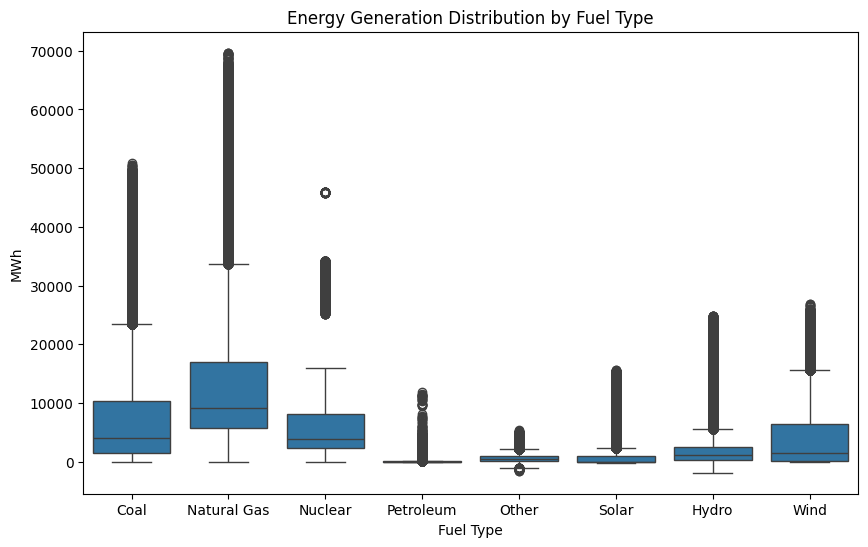

In [4]:
## Plot MWh Distribution by Fuel Type
fuel_dist_plt = plt.figure(figsize=(10, 6))
sns.boxplot(x='type-name', y='value', data=eia_data, legend=False, showfliers=True)
plt.title('Energy Generation Distribution by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('MWh')
# fuel_dist_plt.show()
plt.savefig('../images/MWh_Fuel_type.png')

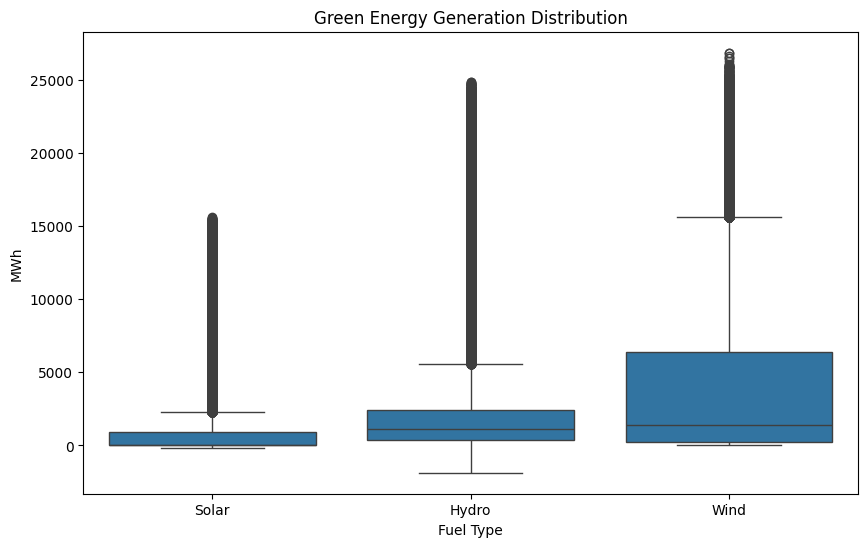

In [5]:
## Mostly curious about Solar, Hydro and Wind
green_data = eia_data[eia_data['type-name'].isin(['Solar', 'Hydro', 'Wind'])].copy()
green_dist_plt = plt.figure(figsize=(10, 6))
sns.boxplot(x='type-name', y='value', data=green_data, legend=False, showfliers=True)
plt.title('Green Energy Generation Distribution')
plt.xlabel('Fuel Type')
plt.ylabel('MWh')
# green_dist_plt.show()
plt.savefig('../images/MWh_Green_type.png')

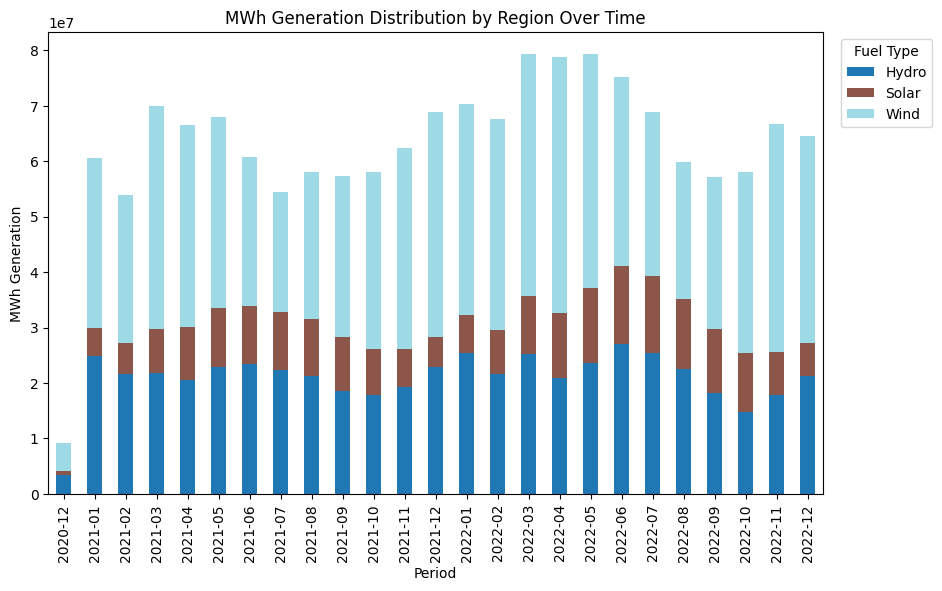

In [6]:
green_resampled = green_data.set_index('date_time').groupby(['respondent-name','type-name']).resample('MS')['value'].sum().reset_index()
green_resampled['date_time'] = green_resampled['date_time'].dt.strftime('%Y-%m')
green_resampled.head()

# Grouping and pivoting the data
grouped_data = green_resampled.groupby(['date_time', 'type-name',]).value.sum().unstack().fillna(0)

# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
grouped_data.plot(kind='bar', stacked=True, ax=ax, colormap='tab20')

# Customizing the plot
plt.title('MWh Generation Distribution by Region Over Time')
plt.xlabel('Period')
plt.ylabel('MWh Generation')
plt.xticks(rotation=90)
plt.legend(title='Fuel Type',bbox_to_anchor=(1.15, 1), loc='upper right')
plt.savefig('../images/MWh_Green_type_time.png')

# EDA for Demand Data

In [7]:
demand = pd.read_feather('demand.feather')
## Ensure column data types are as intended
## adjust sales-units from million kilowatthours to megawatthours
demand['sales'] = pd.to_numeric(demand['sales'])
demand['demand_mwh'] = demand['sales'] *100
demand['date_time'] = pd.to_datetime(demand['period'], format='%Y-%m').dt.strftime('%Y-%m')
## Drop `period` column
demand.drop('period', axis=1, inplace=True)

demand.head()

,stateid,stateDescription,sectorid,sectorName,customers,price,revenue,sales,customers-units,price-units,revenue-units,sales-units,eia_region,demand_mwh,date_time
0,KY,Kentucky,COM,commercial,318852,12.04,190.02917,1578.19245,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,Central,157819.245,2022-12
1,PA,Pennsylvania,ALL,all sectors,6258421,13.23,1717.34932,12976.52290,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,Mid-Atlantic,1297652.290,2022-12
2,OR,Oregon,TRA,transportation,2,10.51,.21752,2.07022,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,Northwest,207.022,2022-12
3,OR,Oregon,RES,residential,1836406,11.13,261.27007,2347.38685,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,Northwest,234738.685,2022-12
4,OR,Oregon,OTH,other,None,None,None,NaN,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,Northwest,NaN,2022-12


In [8]:
demand.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   stateid           10000 non-null  object 
 1   stateDescription  10000 non-null  object 
 2   sectorid          10000 non-null  object 
 3   sectorName        10000 non-null  object 
 4   customers         8335 non-null   object 
 5   price             8335 non-null   object 
 6   revenue           8335 non-null   object 
 7   sales             8335 non-null   float64
 8   customers-units   10000 non-null  object 
 9   price-units       10000 non-null  object 
 10  revenue-units     10000 non-null  object 
 11  sales-units       10000 non-null  object 
 12  eia_region        9610 non-null   object 
 13  demand_mwh        8335 non-null   float64
 14  date_time         10000 non-null  object 
dtypes: float64(2), object(13)
memory usage: 1.2+ MB


In [9]:
## Checkout null values and drop them
demand = demand[demand.notnull().any(axis=1)]

In [10]:
demand.sectorName.unique()

array(['commercial', 'all sectors', 'transportation', 'residential',
       'other', 'industrial'], dtype=object)

/var/folders/s9/9q8cs9l92wd15gsnz7n8f0x40000gn/T/ipykernel_22266/4044186978.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  all_demand_plt.show()


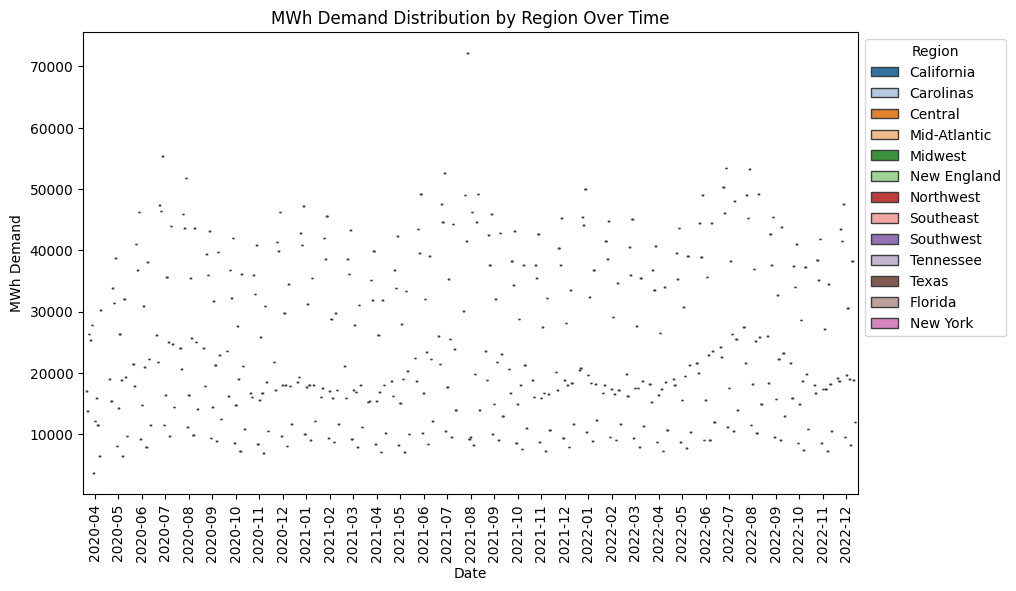

In [11]:
all_demand = demand[demand['sectorName'] == 'all sectors'].copy()
# all_demand['period'] = pd.to_datetime(all_demand['period'], format='%Y-%m').dt.strftime('%Y-%m')
all_demand_plt = plt.figure(figsize=(10, 6))
sns.boxplot(x='date_time', y='sales', data=all_demand.groupby(['date_time','eia_region']).sales.sum().reset_index(), palette='tab20', hue='eia_region')
plt.title('MWh Demand Distribution by Region Over Time')
plt.xlabel('Date')
plt.ylabel('MWh Demand')
plt.xticks(rotation=90)
plt.legend(title='Region',bbox_to_anchor=(1.2, 1), loc='upper right')
all_demand_plt.show()
plt.savefig('../images/MWh_demand.png')

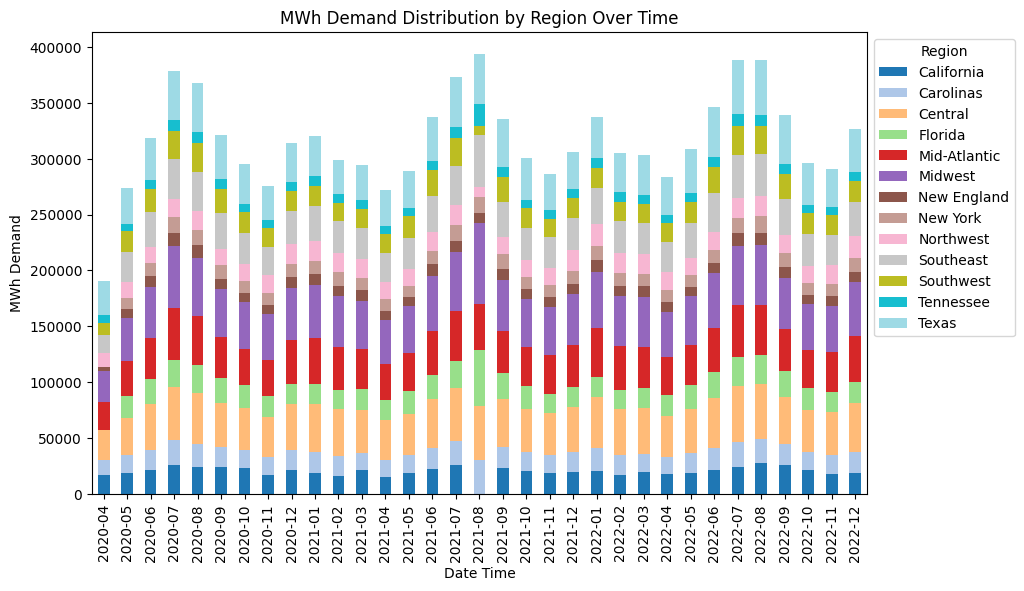

In [12]:
# Grouping and pivoting the data
grouped_data = all_demand.groupby(['date_time', 'eia_region']).sales.sum().unstack().fillna(0)

# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
grouped_data.plot(kind='bar', stacked=True, ax=ax, colormap='tab20')

# Customizing the plot
plt.title('MWh Demand Distribution by Region Over Time')
plt.xlabel('Date Time')
plt.ylabel('MWh Demand')
plt.xticks(rotation=90)
plt.legend(title='Region',bbox_to_anchor=(1.2, 1), loc='upper right')

# Display the plot
plt.show()

# Save the plot
fig.savefig('../images/MWh_demand2.png')

# EDA for Wind, Temperature & Irradiance Data

## Wind & Temperature

In [13]:
weather = pd.read_feather('weather.feather')
## Ensure column data types are as intended
weather.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 24123 entries, 0 to 730
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   index     0 non-null      float64       
 1   tavg      24123 non-null  float64       
 2   tmin      24123 non-null  float64       
 3   tmax      24123 non-null  float64       
 4   prcp      24123 non-null  float64       
 5   snow      14561 non-null  float64       
 6   wdir      24122 non-null  float64       
 7   wspd      24123 non-null  float64       
 8   wpgt      0 non-null      float64       
 9   pres      24123 non-null  float64       
 10  tsun      703 non-null    float64       
 11  coord     24123 non-null  object        
 12  location  24123 non-null  object        
 13  time      24123 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(11), object(2)
memory usage: 2.8+ MB


In [24]:
## Reduce to columns of interest
wind_temp = weather[['time', 'location', 'tavg', 'tmin', 'tmax', 'wdir', 'wspd',]].copy()

In [25]:
wind_temp.head()

,time,location,tavg,tmin,tmax,wdir,wspd
0,2022-01-01,California,5.3,0.6,11.7,64.0,4.7
1,2022-01-02,California,6.2,0.6,13.9,53.0,3.6
2,2022-01-03,California,6.8,0.6,13.9,18.0,3.2
3,2022-01-04,California,8.0,3.3,15.0,41.0,4.0
4,2022-01-05,California,9.9,6.1,14.4,334.0,5.4


In [26]:
wind_temp = wind_temp.groupby(['time','location']).agg(lambda x: x.mean()).reset_index()

,time,location,tavg,tmin,tmax,wdir,wspd
0,2022-01-01,California,8.300000,4.450000,13.900000,32.500000,3.150000
1,2022-01-01,Carolinas,21.133333,18.066667,25.766667,217.666667,17.766667
2,2022-01-01,Central,-10.766667,-15.733333,-5.933333,351.666667,23.566667
3,2022-01-01,Florida,23.533333,20.200000,28.333333,179.000000,11.233333
4,2022-01-01,Mid-Atlantic,13.366667,10.166667,16.400000,150.666667,8.200000


In [27]:
wind_monthly = wind_temp.set_index('time').groupby(['location']).resample('MS')[['tavg','wspd']].mean().reset_index()
wind_monthly.head()

,location,time,tavg,wspd
0,California,2022-01-01,11.777419,2.519355
1,California,2022-02-01,13.016071,6.232143
2,California,2022-03-01,15.753226,8.595161
3,California,2022-04-01,17.558333,10.820000
4,California,2022-05-01,19.764516,10.338710


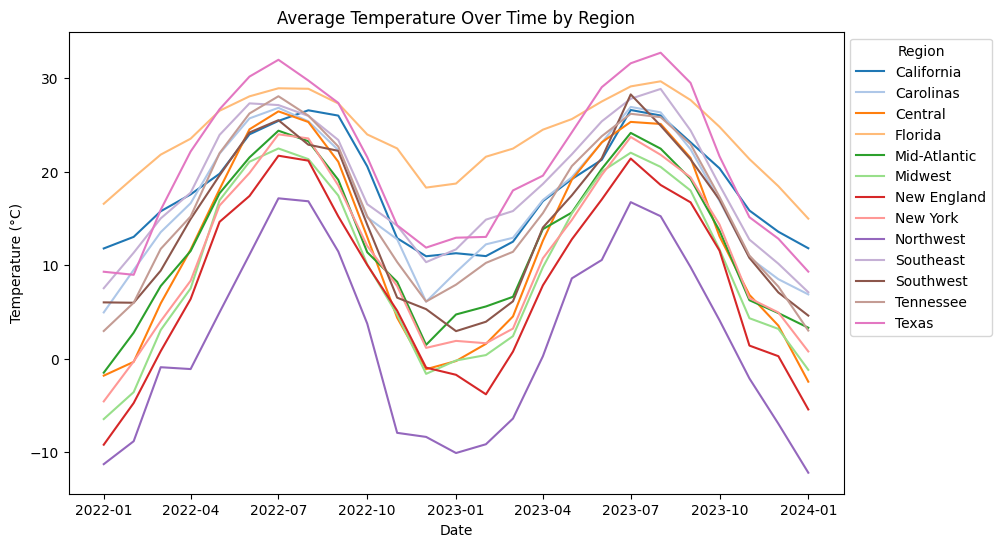

In [33]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='time', y='tavg', data=wind_monthly, hue='location', palette='tab20')
plt.title('Average Temperature Over Time by Region')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
# plt.xticks(rotation=90)
plt.legend(title='Region',bbox_to_anchor=(1.2, 1), loc='upper right')
plt.savefig('../images/avg_temp.png')
plt.show()

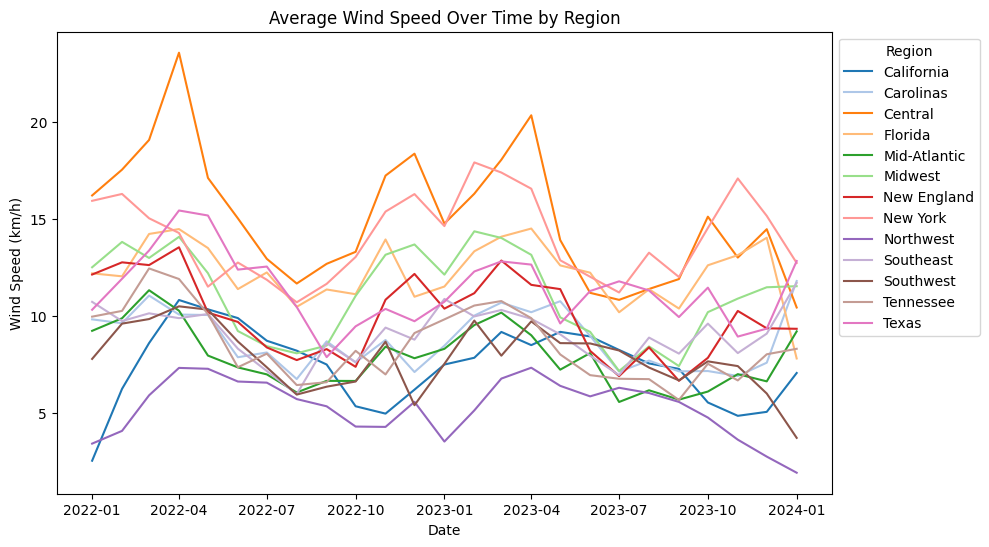

In [31]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='time', y='wspd', data=wind_monthly, hue='location', palette='tab20')
plt.title('Average Wind Speed Over Time by Region')
plt.xlabel('Date')
plt.ylabel('Wind Speed (km/h)')
plt.legend(title='Region',bbox_to_anchor=(1.2, 1), loc='upper right')
plt.savefig('../images/avg_temp.png')
plt.show()

## Irradiance

In [67]:
irradiance = pd.read_feather('irradiance.feather')

In [17]:
irradiance.info(show_counts=True)
irradiance.head(25)

<class 'pandas.core.frame.DataFrame'>
Index: 911040 entries, 0 to 8759
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Year                911040 non-null  int64  
 1   Month               911040 non-null  int64  
 2   Day                 911040 non-null  int64  
 3   Hour                911040 non-null  int64  
 4   Minute              911040 non-null  int64  
 5   GHI                 911040 non-null  int64  
 6   DHI                 911040 non-null  int64  
 7   DNI                 911040 non-null  int64  
 8   Solar Zenith Angle  911040 non-null  float64
 9   eia_region          911040 non-null  object 
 10  coord               911040 non-null  object 
dtypes: float64(1), int64(8), object(2)
memory usage: 83.4+ MB


In [68]:
## Calculate Plane of Array Irradiance (https://pvpmc.sandia.gov/modeling-guide/1-weather-design-inputs/plane-of-array-poa-irradiance/)
irradiance['poa'] = irradiance.GHI + irradiance.DHI + irradiance.DNI

irradiance['month_year']  = pd.to_datetime(irradiance[['Year', 'Month']].assign(day=1))

irradiance.set_index('month_year', inplace=True)
irradiance_resampled = irradiance.groupby('eia_region').resample('MS')['poa'].sum().reset_index()

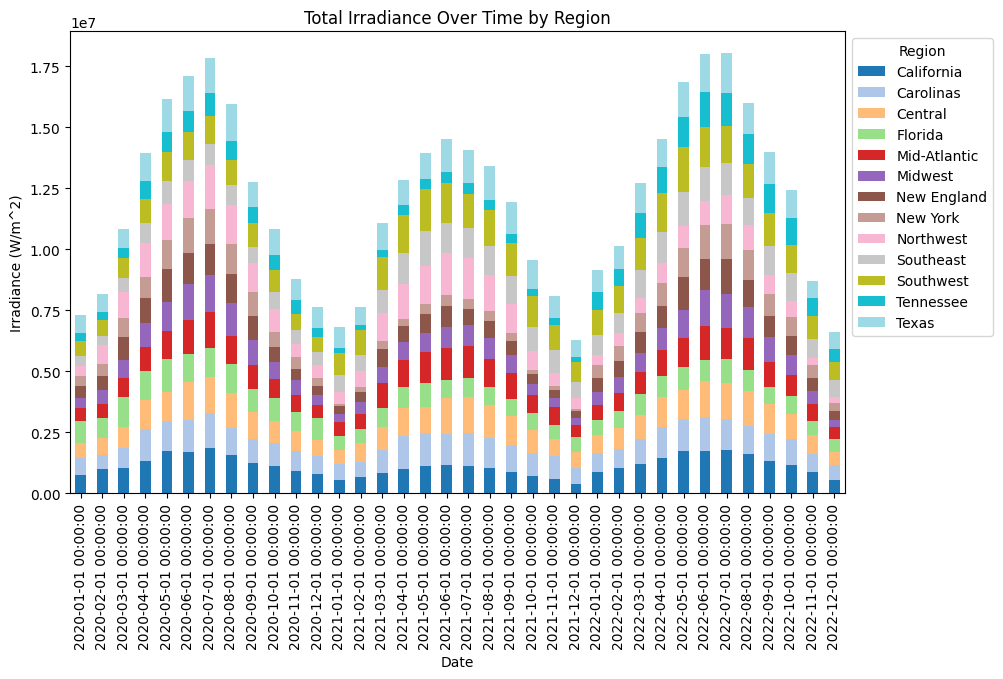

In [79]:
# irradiance_resampled.head()
pivot = irradiance_resampled.pivot(index='month_year', columns='eia_region', values='poa').fillna(0)

# plt.figure(figsize=(10, 6))
# sns.barplot(x='month_year', y='poa', data=irradiance_resampled, hue='eia_region', palette='tab20')
pivot.plot(kind='bar', stacked=True, colormap='tab20', figsize=(10, 6))
plt.title('Total Irradiance Over Time by Region')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Irradiance (W/m^2)')
plt.legend(title='Region',bbox_to_anchor=(1.2, 1), loc='upper right')
plt.savefig('../images/irradiance.png')

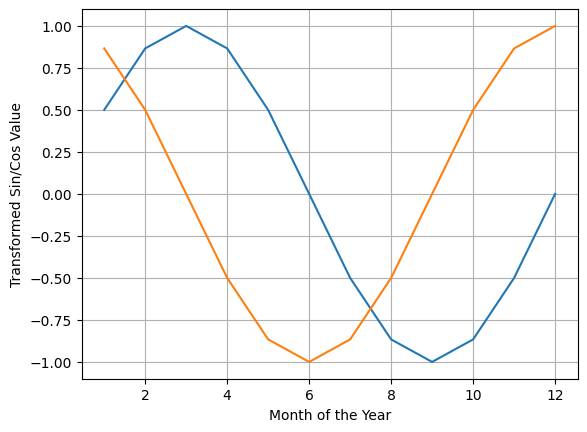

In [39]:
# from sklearn.preprocessing import FunctionTransformer

# def sin_transformer(period: int) -> FunctionTransformer:
#     return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

# def cos_transformer(period: int) -> FunctionTransformer:
#     return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

# def create_sine_cosine_doy_feature(df: pd.DataFrame, date_col: str) -> pd.DataFrame:
#     df['month'] = df[date_col].dt.month
#     df['month_sin'] = sin_transformer(12).fit_transform(df['month'])
#     df['month_cos'] = cos_transformer(12).fit_transform(df['month'])
#     return df

# test_df = pd.DataFrame({
#     'snapshot_date': pd.date_range(start='1/1/2023', end='12/31/2023')
# })

# test_df = create_sine_cosine_doy_feature(test_df, 'snapshot_date')

# plt.plot(test_df.month, test_df[['month_sin', 'month_cos']])
# plt.xlabel('Month of the Year')
# plt.ylabel('Transformed Sin/Cos Value')
# plt.grid()